# 策略简介

本周学校课程“机器学习与量化投资”布置了作业“构建并回测基于三因子模型的周度百股策略”，但是要求基于SAS软件实现。

考虑到这一模型策略涉及到了基本面因子，也有最简单的技术面因子，比较均衡。于是我将其用Python实现，作为实习生测试的策略。

（本来想实现一个“适度冒险因子”，但是该策略涉及到分钟级量价数据，数据量很大，可以获得，但是无法通过邮箱等渠道发送，于是放弃）

![clsl](readme/clsl.png)

# 环境与数据准备

In [2]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import os
import gc
from zipfile import ZipFile
import warnings
warnings.filterwarnings('ignore')

from quantools import backtest

In [ ]:
with ZipFile("../data/stk_data.zip", 'r') as zfile:
    f = zfile.open(f'stk_data.csv')
    stk_data = pd.read_csv(f)
stk_data['close_date'] = pd.to_datetime(stk_data['close_date'])
stk_data['open_date'] = pd.to_datetime(stk_data['open_date'])

with ZipFile("../data/open_days_data.zip", 'r') as zfile:
    f = zfile.open(f'open_days_data.csv')
    open_days_data = pd.read_csv(f)
open_days_data['date'] = pd.to_datetime(open_days_data['date'])

equity = pd.read_csv("../data/eqy_belongto_parcomsh.csv")
equity['rpt_date'] = pd.to_datetime(equity['rpt_date'])

os.mkdir("../cal_data") # 存储计算结果的路径

In [ ]:
# 沪深两市股票20060101-20230928周度股票数据 
# stock_code:股票代码
# open_date:开盘时间
# close_date:收盘时间
# open:后复权开盘价
# close:后复权收盘价
# uadj_close:未复权收盘价
# total_shares:总股本数

print(stk_data.shape)
stk_data.head()

(4583825, 7)


,TOTAL_SHARES,CLOSE,OPEN,stock_code,open_date,close_date,uadj_close
0,1.945822e+09,160.348451,153.344151,000001.SZ,2006-01-04,2006-01-06,6.41
1,1.945822e+09,155.345379,160.098298,000001.SZ,2006-01-09,2006-01-13,6.21
2,1.945822e+09,155.845687,154.594919,000001.SZ,2006-01-16,2006-01-20,6.23
3,1.945822e+09,158.847530,155.845687,000001.SZ,2006-01-23,2006-01-25,6.35
4,1.945822e+09,155.345379,158.847530,000001.SZ,2006-02-06,2006-02-10,6.21


In [ ]:
# 沪深两市上市公司20050930-20230630报告期内归属母公司的股东权益数据 
# stock_code:股票代码
# rpt_date:报告期日期
# eqy_belongto_parcomsh:归属母公司的股东权益
print(equity.shape)
equity.head()

(375377, 3)


,stock_code,EQY_BELONGTO_PARCOMSH,rpt_date
0,000001.SZ,5.014966e+09,2005-09-30
1,000002.SZ,6.738774e+09,2005-09-30
2,000004.SZ,8.952654e+07,2005-09-30
3,000005.SZ,8.290555e+08,2005-09-30
4,000006.SZ,1.007023e+09,2005-09-30


In [ ]:
# 沪深两市股票20060101-20230928，每周开盘日的高开低收量
# stock_code:股票代码
# date:交易日期
# high:最高价
# open:开盘价
# low:最低价
# close:收盘价
# volume:交易量

print(open_days_data.shape)
open_days_data.head()

(4599020, 7)


,stock_code,HIGH,OPEN,LOW,CLOSE,VOLUME,date
0,000001.SZ,158.347222,153.344151,153.093997,157.096455,15445068.0,2006-01-04
1,000002.SZ,206.631220,194.684662,194.684662,206.188755,38931043.0,2006-01-04
2,000004.SZ,13.191923,13.035620,12.941839,13.098141,401500.0,2006-01-04
3,000005.SZ,9.436105,9.155268,9.042934,9.379937,3713641.0,2006-01-04
4,000006.SZ,18.698245,18.698245,18.698245,18.698245,0.0,2006-01-04


# 数据计算

## 计算三因子

In [ ]:
# 计算市值
stk_data['mkt_cap'] = stk_data['TOTAL_SHARES'] * stk_data['uadj_close']

# 计算每个交易周对应的报告期（用于匹配所有者权益）
def match_rpt_date(date):
    """
        将日期转化为对应的报告期；
        基于：一季报最晚4/30公布，半年报8/30，三季报10/30，年报来年4/30（因此不用）
    """
    y = date.year
    m = date.month
    if m in (5, 6, 7, 8): return f"{y}0331"
    elif m in (9, 10): return f"{y}0630"
    elif m in (11, 12): return f"{y}0930"
    elif m in (1, 2, 3, 4): return f"{y-1}0930"

stk_data['rpt_date'] = pd.to_datetime(stk_data['close_date'].apply(lambda x: match_rpt_date(x)))

In [ ]:
all_data = pd.merge(stk_data, equity, on=['stock_code', 'rpt_date'], how='left')

In [ ]:
odd = {}
for key in tqdm(['HIGH', 'OPEN', 'LOW', 'CLOSE', 'VOLUME']):
    odd[key] = pd.pivot(open_days_data, index='date', columns='stock_code', values=key)

100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


In [ ]:
odd['pred_rtn'] = (odd['OPEN'].shift(-2)-odd['OPEN'].shift(-1))/odd['OPEN'].shift(-1)

pred_rtn_na = odd['pred_rtn'].isna() # 不要把空值变成0

# 下周停牌的股票只能获得0的收益
vol0 = odd['VOLUME'].shift(-1)==0 
volna = odd['VOLUME'].shift(-1).isna()
odd['pred_rtn'][vol0 | volna & (~pred_rtn_na)] = 0 

# 下周一字涨停的股票无法买入，只能获得0的收益
yz = odd['HIGH'].shift(-1)==odd['LOW'].shift(-1) # “一字”，价格没有变化
zt = ~(odd['CLOSE'].shift(-1) <= odd['CLOSE']) # “涨停”，价格不比上周高
odd['pred_rtn'][yz & zt & (~pred_rtn_na)] = 0 

pred_rtn = odd['pred_rtn'].stack().reset_index().rename(columns={0: 'pred_rtn', 'date': 'open_date'})

all_data = pd.merge(all_data, pred_rtn, on=['open_date', 'stock_code'], how='left')
all_data = all_data[~all_data['pred_rtn'].isna()]

del odd
gc.collect() # 释放内存

26

In [ ]:
# 计算周收益率因子
close = pd.pivot(all_data, index='close_date', columns='stock_code', values='CLOSE')
fac_ret = (close-close.shift(1))/close.shift(1)
fac_ret = fac_ret.stack().reset_index().rename(columns={0: 'fac_ret', 'date': 'close_date'})
all_data = pd.merge(all_data, fac_ret, on=['close_date', 'stock_code'], how='left')

# 计算规模因子
all_data['fac_size'] = np.log(all_data['mkt_cap']/1000000)

# 账面市值比因子
all_data['fac_bm'] = all_data['EQY_BELONGTO_PARCOMSH'] / all_data['mkt_cap']

In [ ]:
factors = all_data[['stock_code', 'close_date', 'pred_rtn', 'fac_ret', 'fac_size', 'fac_bm']].reset_index(drop=True)
factors = factors[~factors['pred_rtn'].isna()]
factors.head()

,stock_code,close_date,pred_rtn,fac_ret,fac_size,fac_bm
0,000001.SZ,2006-01-06,-0.034375,NaN,9.431299,0.402075
1,000001.SZ,2006-01-13,0.008091,-0.031201,9.399601,0.415024
2,000001.SZ,2006-01-20,0.019262,0.003221,9.402816,0.413692
3,000001.SZ,2006-01-25,-0.022047,0.019262,9.421895,0.405874
4,000001.SZ,2006-02-10,0.004831,-0.022047,9.399601,0.415024


In [ ]:
factors.to_csv("../cal_data/factors.csv", index=False)

## 因子截尾处理

<Axes: ylabel='Density'>

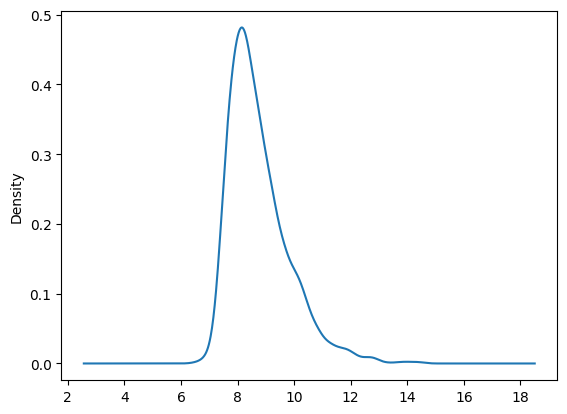

In [ ]:
# 截尾前(没有偏好，随便选的)
fac_name = 'fac_size'
factors[factors['close_date']=='2019-10-18'][fac_name].plot.kde(title="2019-10-18日 Size因子分布情况（截尾前）")

In [ ]:
factors = backtest.winsorize_factor(factors, 'fac_size')
factors = backtest.winsorize_factor(factors, 'fac_ret')
factors = backtest.winsorize_factor(factors, 'fac_bm')

Winsorizing the factor fac_bm: 100%|██████████| 2443656/2443656 [00:51<00:00, 47311.93it/s]


<Axes: ylabel='Density'>

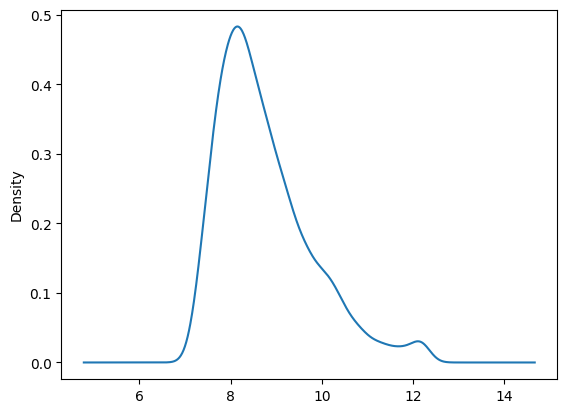

In [ ]:
# 截尾后
factors[factors['close_date']=='2019-10-18'][fac_name].plot.kde(title="2019-10-18日 Size因子分布情况（截尾后）")

# 对单个因子测试

## 通过Fama-MacBeth回归验证模型效果

In [ ]:
res_list = []
for fac_name in ['fac_size', 'fac_ret', 'fac_bm']:
    res_list.append(backtest.fama_macbeth(factors, fac_name))
fama_macbeth_res = pd.DataFrame(res_list)
fama_macbeth_res

Fama-MacBeth Regression by factor fac_bm: 100%|██████████| 904/904 [00:01<00:00, 870.63it/s] 


,fac_name,t,p,pos_count,neg_count
0,fac_size,-4.576268,5.395101e-06,362,541
1,fac_ret,-10.642792,5.330462e-25,290,612
2,fac_bm,4.019551,6.317205e-05,464,439


针对这一分析结果，三个因子t检验显著区别于0，是比较有效的因子；而其中账面市值比显著为正，其他两个显著为负数，也符合日常学术研究中对其的认知。

其中，账面市值比因子回归后斜率分别为正负的数量基本相同，区分效应较差，因此从这一维度来说，他的效果并不是很好。

## 单因子分组收益情况

Calculating groups: 100%|██████████| 10/10 [00:00<00:00, 17.81it/s]


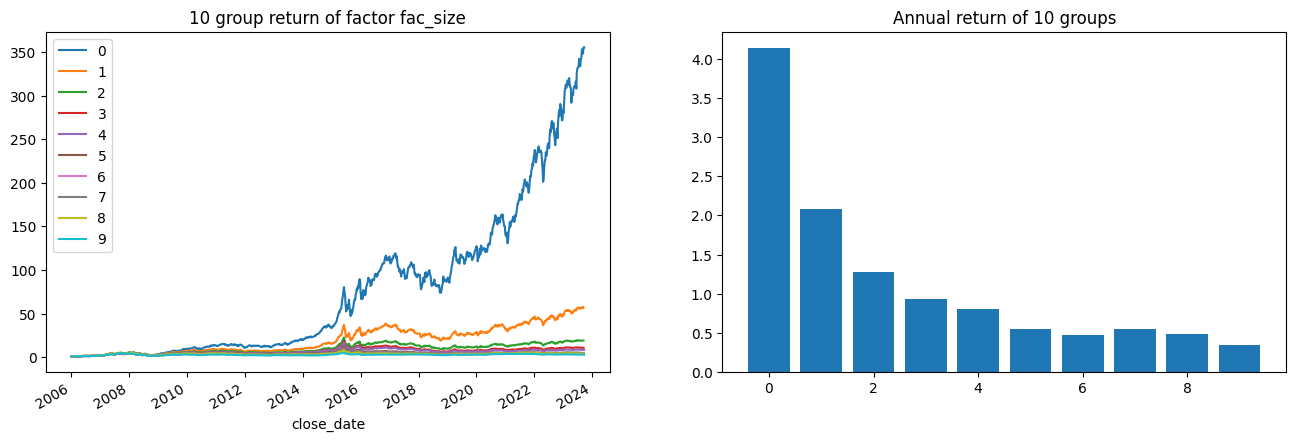

In [ ]:
group_rtns, group_cum_rtns = backtest.group_return_analysis(factors, 'fac_size')

Calculating groups: 100%|██████████| 10/10 [00:00<00:00, 14.54it/s]


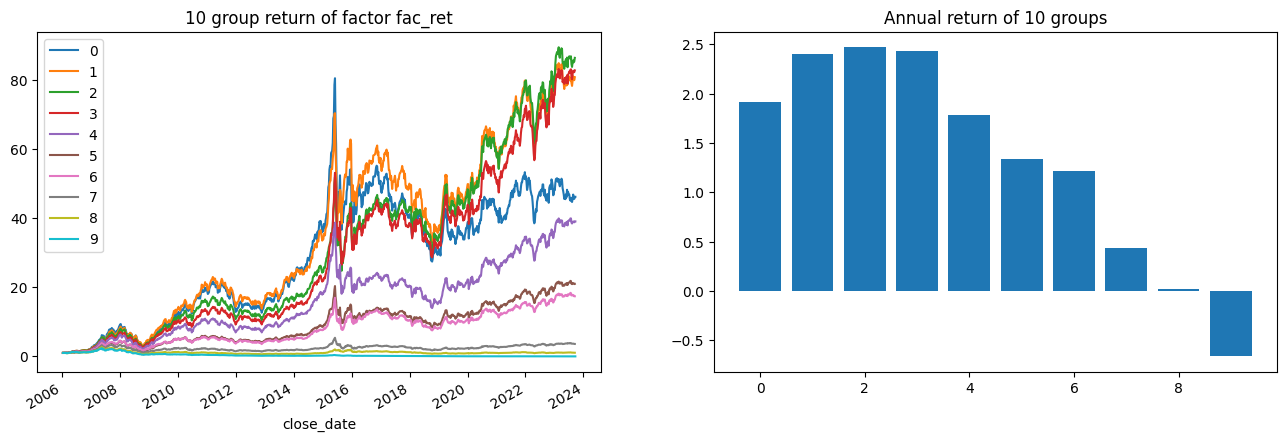

In [ ]:
group_rtns, group_cum_rtns = backtest.group_return_analysis(factors, 'fac_ret')

Calculating groups: 100%|██████████| 10/10 [00:00<00:00, 15.48it/s]


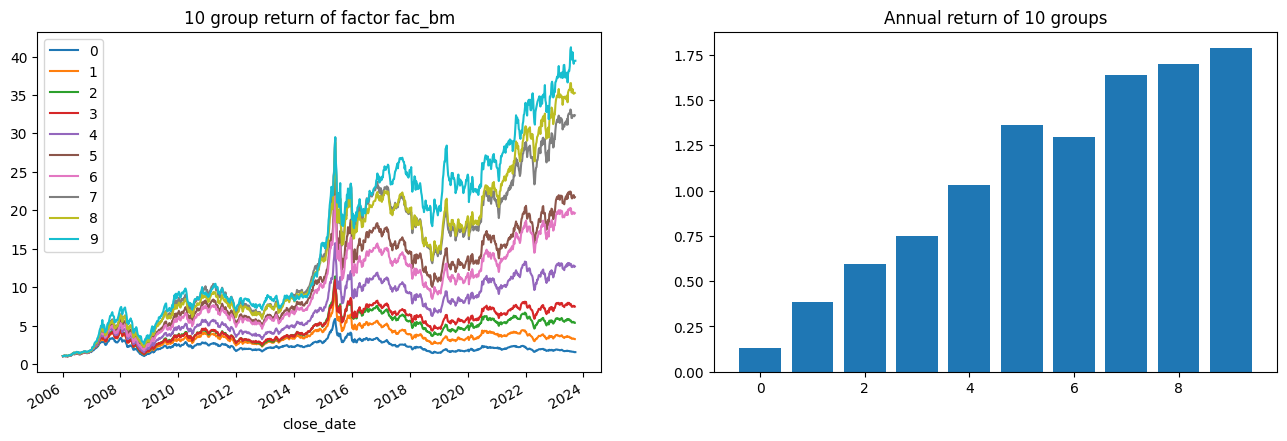

In [ ]:
group_rtns, group_cum_rtns = backtest.group_return_analysis(factors, 'fac_bm')

回测后看出，三个因子都有一定的分组效果，其中账面市值比与市值因子分组效果最好，收益率因子分组效果相对差一些。

## 单因子周度百股策略回测

,sharpe_ratio,max_drawdown,max_drawdown_start,max_drawdown_end,sortino_ratio,annual_return,annual_volatility,section
0,1.405346,0.789046,2015-06-05,2018-10-12,2.030548,1.178091,0.763147,Sum
1,6.653799,0.108753,2006-06-30,2006-07-28,9.882821,67.674182,0.674358,2006
2,7.957098,0.217392,2007-05-18,2007-06-22,11.966749,1336.033077,0.975551,2007
3,-2.535012,0.699955,2008-01-11,2008-10-24,-4.945847,-0.975181,1.181429,2008
4,6.570332,0.143081,2009-02-06,2009-02-20,8.999942,121.088407,0.783940,2009
5,3.688373,0.198535,2010-04-02,2010-06-25,6.296923,9.382755,0.702845,2010
6,-3.329041,0.426803,2011-07-08,2011-12-30,-4.826786,-0.906297,0.645434,2011
7,1.483952,0.243869,2012-03-02,2012-11-23,2.545457,1.049363,0.604799,2012
8,4.117017,0.134629,2013-05-24,2013-06-21,7.282607,7.479792,0.558735,2013
9,4.479553,0.096290,2014-11-21,2014-12-26,9.303073,8.344907,0.531904,2014


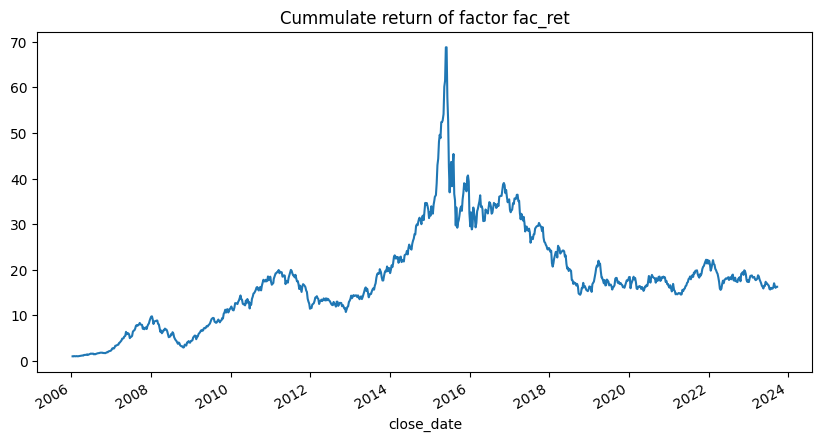

In [ ]:
rtn, evaluate_result = backtest.backtest_1week_nstock(factors, 'fac_ret', True)
evaluate_result

,sharpe_ratio,max_drawdown,max_drawdown_start,max_drawdown_end,sortino_ratio,annual_return,annual_volatility,section
0,3.122859,0.610775,2008-01-11,2008-10-24,4.453695,5.248983,0.658517,Sum
1,3.780915,0.082394,2006-09-29,2006-11-10,6.824324,7.448274,0.615477,2006
2,7.619150,0.277240,2007-05-18,2007-06-22,7.588304,550.342103,0.891182,2007
3,-1.678621,0.610775,2008-01-11,2008-10-24,-2.910806,-0.884322,0.992800,2008
4,7.547957,0.115055,2009-02-06,2009-02-20,10.933357,167.053901,0.719293,2009
5,3.022128,0.245051,2010-04-02,2010-06-25,4.223931,4.525651,0.633368,2010
6,-1.694132,0.302932,2011-04-15,2011-12-30,-2.558479,-0.681412,0.576306,2011
7,2.662808,0.146320,2012-03-02,2012-11-23,4.112191,3.122259,0.600360,2012
8,5.374411,0.131401,2013-05-24,2013-06-21,8.249390,9.844832,0.465409,2013
9,7.121590,0.112333,2014-11-21,2014-12-26,13.799625,13.415354,0.386941,2014


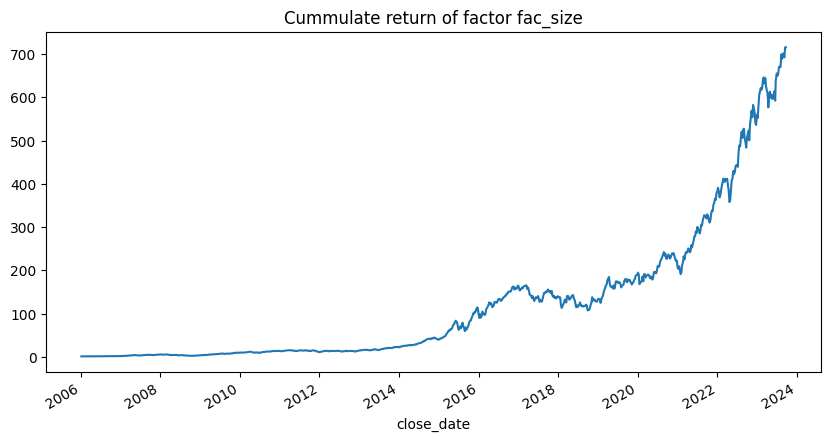

In [ ]:
rtn, evaluate_result = backtest.backtest_1week_nstock(factors, 'fac_size', True)
evaluate_result

,sharpe_ratio,max_drawdown,max_drawdown_start,max_drawdown_end,sortino_ratio,annual_return,annual_volatility,section
0,2.006960,0.638422,2008-01-11,2008-10-24,2.918252,1.847405,0.617145,Sum
1,5.618410,0.105872,2006-06-30,2006-08-11,9.420005,21.852138,0.590378,2006
2,7.354710,0.281662,2007-05-18,2007-06-22,8.206541,980.089048,1.019448,2007
3,-2.479428,0.638422,2008-01-11,2008-10-24,-4.484640,-0.960315,1.067600,2008
4,6.410670,0.142736,2009-02-06,2009-02-20,10.016987,131.546624,0.820762,2009
5,0.156546,0.274959,2010-04-02,2010-06-25,0.242633,-0.062901,0.555388,2010
6,-2.983162,0.329127,2011-04-15,2011-12-30,-5.263885,-0.730526,0.410657,2011
7,2.215259,0.162853,2012-02-24,2012-09-14,4.250416,1.304317,0.415575,2012
8,0.477065,0.207478,2013-02-01,2013-06-21,0.842547,0.122281,0.450571,2013
9,7.128198,0.057684,2014-02-07,2014-03-07,16.469641,20.726504,0.448048,2014


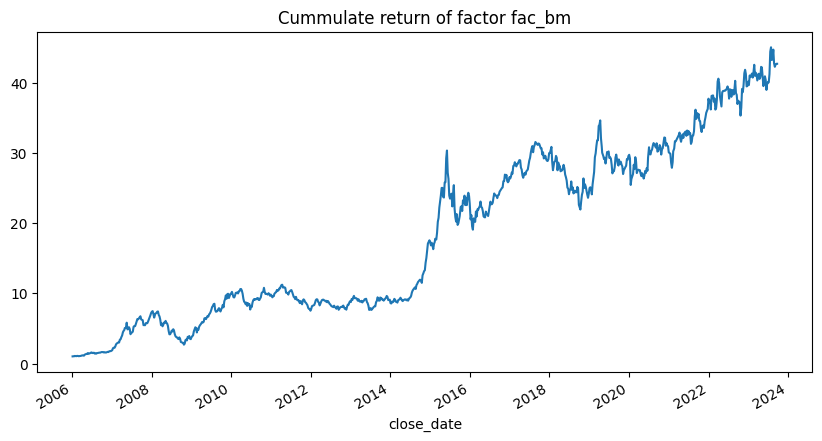

In [ ]:
rtn, evaluate_result = backtest.backtest_1week_nstock(factors, 'fac_bm')
evaluate_result

# 多因子组合

## 简单分组打分法

,sharpe_ratio,max_drawdown,max_drawdown_start,max_drawdown_end,sortino_ratio,annual_return,annual_volatility,section
0,2.762777,0.606990,2008-02-29,2008-10-24,3.828052,4.585105,0.718640,Sum
1,5.532422,0.102080,2006-06-30,2006-08-11,10.268628,26.228477,0.636676,2006
2,8.101543,0.287660,2007-05-18,2007-06-22,8.857011,2223.268814,1.031276,2007
3,-0.937202,0.606990,2008-02-29,2008-10-24,-1.643112,-0.829617,1.169914,2008
4,7.927451,0.138606,2009-02-06,2009-02-20,11.627565,466.483920,0.826747,2009
5,4.065468,0.241853,2010-04-02,2010-06-25,5.996514,11.165462,0.672587,2010
6,-2.182011,0.333801,2011-03-18,2011-12-30,-3.358018,-0.776748,0.602593,2011
7,2.119900,0.196653,2012-03-02,2012-11-23,3.458198,1.997337,0.603504,2012
8,4.936706,0.168503,2013-05-24,2013-06-21,7.691246,9.718052,0.508523,2013
9,5.649539,0.083951,2014-11-21,2014-12-26,11.179287,9.436769,0.433277,2014


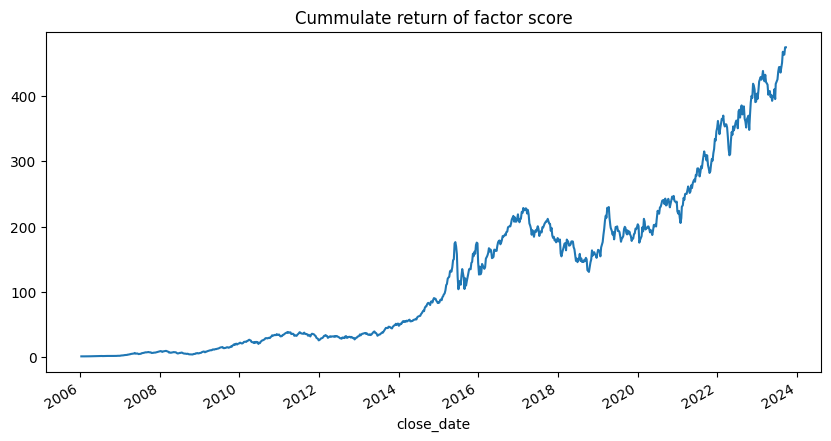

In [ ]:
rtn, evaluate_result = backtest.mutifactor_score(factors, ['-fac_ret', '-fac_size', 'fac_bm'], group_num=10)
evaluate_result

相比于单个”市值“因子，因子组合后效果变差了。

## 多元回归选股法

Calculating regression return: 100%|██████████| 2433686/2433686 [01:12<00:00, 33529.83it/s]


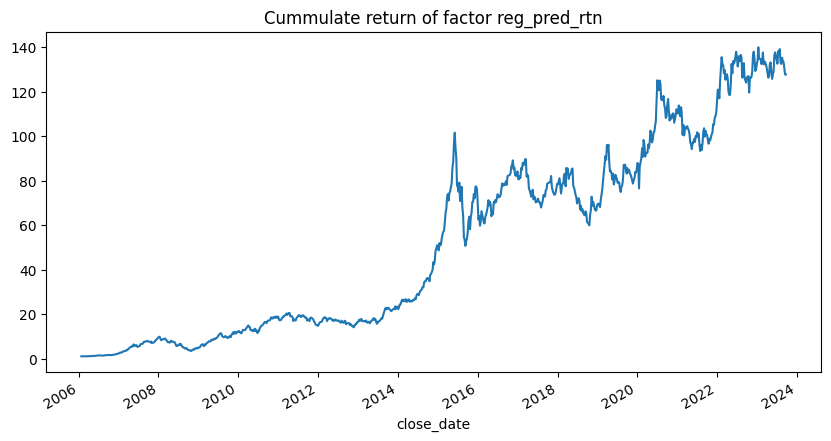

In [ ]:
rtn, evaluate_result = backtest.mutifactor_regression(factors, ['fac_ret', 'fac_size', 'fac_bm'], stock_num=100, plot=True)

In [ ]:
evaluate_result

,sharpe_ratio,max_drawdown,max_drawdown_start,max_drawdown_end,sortino_ratio,annual_return,annual_volatility,section
0,2.381925,0.653284,2008-01-11,2008-10-24,3.633037,2.883003,0.663260,Sum
1,7.397497,0.083543,2006-07-21,2006-08-11,14.551758,80.247146,0.625025,2006
2,8.605610,0.176219,2007-05-18,2007-06-22,12.445344,1427.010829,0.901967,2007
3,-2.899683,0.653284,2008-01-11,2008-10-24,-5.515209,-0.960043,0.949763,2008
4,5.760640,0.194681,2009-07-24,2009-09-25,10.102339,88.968733,0.848765,2009
5,3.671218,0.230784,2010-04-02,2010-06-25,5.466090,8.329292,0.671275,2010
6,-2.037976,0.284170,2011-04-08,2011-12-30,-3.026109,-0.713988,0.541419,2011
7,1.235993,0.245804,2012-03-02,2012-11-23,2.141001,0.664276,0.520239,2012
8,3.641103,0.138178,2013-05-24,2013-06-21,6.342497,4.966395,0.530263,2013
9,7.529679,0.045554,2014-03-14,2014-03-21,17.314748,37.479723,0.504501,2014


对比前面的诸多策略，该策略的收益率并不算高（尤其和市值因子相比），这也是因为我们回归后的系数滞后了两周才进行预测的结果。

但是，整体来看该策略的效果是比Ret,B/M因子的效果好的，而且相比于Size因子，该策略可以很好的消除市场风格的影响。

在2017年的大盘股行情中，该策略的最大回撤只有25%，比单纯的Size因子好很多。